In [63]:
import tensorflow as tf

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [64]:
pip install -q git+https://github.com/tensorflow/examples.git

In [65]:
import tensorflow_datasets as tfds
from tensorflow_examples.models.pix2pix import pix2pix
import cv2
from google.colab.patches import cv2_imshow
import os
import time
import matplotlib.pyplot as plt
from IPython.display import clear_output

AUTOTUNE = tf.data.AUTOTUNE

In [72]:
pip install pytube

     |████████████████████████████████| 51kB 2.3MB/s 


In [74]:
import pytube

url = 'https://www.youtube.com/watch?v=06-XXOTP3Gc'

youtube = pytube.YouTube(url)
video = youtube.streams.first()
video.download('drive/MyDrive/Frames/Video/')

'/content/drive/MyDrive/Frames/Video/Shane Filan - Beautiful In White (Official Video).mp4'

In [75]:
video = cv2.VideoCapture("drive/MyDrive/Frames/Video/Shane Filan - Beautiful In White (Official Video).mp4")
fps = video.get(cv2.CAP_PROP_FPS)
fps

25.0

In [56]:

# Opens the Video file
cap= cv2.VideoCapture('drive/MyDrive/Frames/Video/4K HDR 60FPS ● Sniper Will Smith (Gemini Man) ● Dolby Vision ● Dolby Atmos.mp4')
i=0
while(cap.isOpened()):
    ret, frame = cap.read()
    if ret == False:
        break
    if i%25==0:
      cv2.imwrite('drive/MyDrive/Frames/Coloured/train'+str(i)+'.jpg',frame)
      cv2.imwrite('drive/MyDrive/Frames/Uncoloured/train'+str(i)+'.jpg',cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY))
    i+=1
 
cap.release()
cv2.destroyAllWindows()

In [ ]:
img = cv2.imread('drive/MyDrive/Frames/Uncoloured/train200.jpg')
cv2_imshow(img)

In [ ]:
img = cv2.imread('drive/MyDrive/Frames/Coloured/train200.jpg')
cv2_imshow(img)

In [6]:
BUFFER_SIZE = 2000
BATCH_SIZE = 1
IMG_WIDTH = 256
IMG_HEIGHT = 256

In [7]:
PATH_black = 'drive/MyDrive/Frames/Uncoloured'
PATH_color = 'drive/MyDrive/Frames/Coloured'

In [8]:
def load(image_file):
  image = tf.io.read_file(image_file)
  image = tf.image.decode_jpeg(image,channels=3)
  input_image = tf.cast(image, tf.float32)

  return input_image

In [9]:
def resize(input_image, height, width):
  input_image = tf.image.resize(input_image, [height, width],
                                method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

  return input_image

In [10]:
def random_crop(input_image):
  cropped_image = tf.image.random_crop(
      input_image, size=[ IMG_HEIGHT, IMG_WIDTH, 3])

  return cropped_image

In [11]:
def normalize(input_image):
  input_image = (input_image / 127.5) - 1
  return input_image

In [12]:
def random_jitter(input_image):
  # resizing to 286 x 286 x 3
  input_image = resize(input_image, 286, 286)

  # randomly cropping to 256 x 256 x 3
  input_image = random_crop(input_image)

  if tf.random.uniform(()) > 0.5:
    # random mirroring
    input_image = tf.image.flip_left_right(input_image)

  return input_image

In [13]:
def load_image_train(image_file):
  input_image = load(image_file)
  input_image = random_jitter(input_image)
  input_image = normalize(input_image)

  return input_image

In [14]:
train_black = tf.data.Dataset.list_files(PATH_black+'/*.jpg')
train_color = tf.data.Dataset.list_files(PATH_color+'/*.jpg')

In [15]:
train_black = train_black.map(load_image_train,
                                  num_parallel_calls=tf.data.AUTOTUNE)
train_black = train_black.shuffle(BUFFER_SIZE)
train_black = train_black.batch(BATCH_SIZE)

In [16]:
train_color = train_color.map(load_image_train,
                                  num_parallel_calls=tf.data.AUTOTUNE)
train_color = train_color.shuffle(BUFFER_SIZE)
train_color = train_color.batch(BATCH_SIZE)

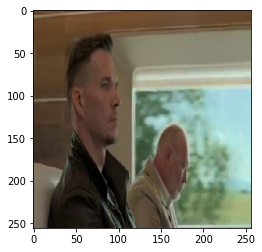

In [17]:
for img in train_color.take(1):
  plt.imshow(img.numpy()[0]*0.5+0.5)

In [67]:
OUTPUT_CHANNELS = 3

generator_g = pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')
generator_f = pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')

discriminator_x = pix2pix.discriminator(norm_type='instancenorm', target=False)
discriminator_y = pix2pix.discriminator(norm_type='instancenorm', target=False)

In [19]:
LAMBDA = 10
loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [20]:
def discriminator_loss(real, generated):
  real_loss = loss_obj(tf.ones_like(real), real)

  generated_loss = loss_obj(tf.zeros_like(generated), generated)

  total_disc_loss = real_loss + generated_loss

  return total_disc_loss * 0.5

In [21]:
def generator_loss(generated):
  return loss_obj(tf.ones_like(generated), generated)

In [22]:
def calc_cycle_loss(real_image, cycled_image):
  loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))

  return LAMBDA * loss1

In [23]:
def identity_loss(real_image, same_image):
  loss = tf.reduce_mean(tf.abs(real_image - same_image))
  return LAMBDA * 0.5 * loss

In [24]:
generator_g_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
generator_f_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

discriminator_x_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_y_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [68]:
checkpoint_path = "drive/MyDrive/Frames/checkpoints/train"

ckpt = tf.train.Checkpoint(generator_g=generator_g,
                           generator_f=generator_f,
                           discriminator_x=discriminator_x,
                           discriminator_y=discriminator_y,
                           generator_g_optimizer=generator_g_optimizer,
                           generator_f_optimizer=generator_f_optimizer,
                           discriminator_x_optimizer=discriminator_x_optimizer,
                           discriminator_y_optimizer=discriminator_y_optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=1)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
  ckpt.restore(ckpt_manager.latest_checkpoint)
  print ('Latest checkpoint restored!!')

Latest checkpoint restored!!


In [57]:
def generate_images(model, test_input):
  prediction = model(test_input)

  plt.figure(figsize=(12, 12))

  display_list = [test_input[0], prediction[0]]
  title = ['Input Image', 'Predicted Image']

  for i in range(2):
    plt.subplot(1, 2, i+1)
    plt.title(title[i])
    # getting the pixel values between [0, 1] to plot it.
    plt.imshow(display_list[i] * 0.5 + 0.5)
    plt.axis('off')
  plt.show()

In [34]:
@tf.function
def train_step(real_x, real_y):
  # persistent is set to True because the tape is used more than
  # once to calculate the gradients.
  with tf.GradientTape(persistent=True) as tape:
    # Generator G translates X -> Y
    # Generator F translates Y -> X.

    fake_y = generator_g(real_x, training=True)
    cycled_x = generator_f(fake_y, training=True)

    fake_x = generator_f(real_y, training=True)
    cycled_y = generator_g(fake_x, training=True)

    # same_x and same_y are used for identity loss.
    same_x = generator_f(real_x, training=True)
    same_y = generator_g(real_y, training=True)

    disc_real_x = discriminator_x(real_x, training=True)
    disc_real_y = discriminator_y(real_y, training=True)

    disc_fake_x = discriminator_x(fake_x, training=True)
    disc_fake_y = discriminator_y(fake_y, training=True)

    # calculate the loss
    gen_g_loss = generator_loss(disc_fake_y)
    gen_f_loss = generator_loss(disc_fake_x)

    total_cycle_loss = calc_cycle_loss(real_x, cycled_x) + calc_cycle_loss(real_y, cycled_y)

    # Total generator loss = adversarial loss + cycle loss
    total_gen_g_loss = gen_g_loss + total_cycle_loss + identity_loss(real_y, same_y)
    total_gen_f_loss = gen_f_loss + total_cycle_loss + identity_loss(real_x, same_x)
    
    disc_x_loss = discriminator_loss(disc_real_x, disc_fake_x)
    disc_y_loss = discriminator_loss(disc_real_y, disc_fake_y)

  # Calculate the gradients for generator and discriminator
  generator_g_gradients = tape.gradient(total_gen_g_loss, 
                                        generator_g.trainable_variables)
  generator_f_gradients = tape.gradient(total_gen_f_loss, 
                                        generator_f.trainable_variables)

  discriminator_x_gradients = tape.gradient(disc_x_loss, 
                                            discriminator_x.trainable_variables)
  discriminator_y_gradients = tape.gradient(disc_y_loss, 
                                            discriminator_y.trainable_variables)

  # Apply the gradients to the optimizer
  generator_g_optimizer.apply_gradients(zip(generator_g_gradients, 
                                            generator_g.trainable_variables))

  generator_f_optimizer.apply_gradients(zip(generator_f_gradients, 
                                            generator_f.trainable_variables))

  discriminator_x_optimizer.apply_gradients(zip(discriminator_x_gradients,
                                                discriminator_x.trainable_variables))

  discriminator_y_optimizer.apply_gradients(zip(discriminator_y_gradients,
                                                discriminator_y.trainable_variables))
  return total_gen_g_loss,total_gen_f_loss

In [ ]:
g_g_loss = []
g_f_loss = []
EPOCHS = 40
for epoch in range(EPOCHS):
  start = time.time()
  g_loss = 0
  f_loss = 0
  n = 0
  for image_x, image_y in tf.data.Dataset.zip((train_black, train_color)):
    g,f = train_step(image_x, image_y)
    g_loss += g
    f_loss += f
    if n % 100 == 0:
      print ('.', end='')
    n += 1
  g_g_loss.append(g_loss)
  g_f_loss.append(f_loss)
  clear_output(wait=True)
  # Using a consistent image (sample_horse) so that the progress of the model
  # is clearly visible.
  for img in train_black.take(1):
    generate_images(generator_g, img)
                    
  if (epoch+1)%10 == 0:
    plt.plot(g_g_loss)
    plt.plot(g_f_loss)
    plt.show()
    plt.savefig("plot.png")
  if (epoch + 1) % 5 == 0:
    ckpt_save_path = ckpt_manager.save()
    print ('Saving checkpoint for epoch {} at {}'.format(epoch+1,
                                                         ckpt_save_path))

  print ('Time taken for epoch {} is {} sec\n'.format(epoch + 1,
                                                      time.time()-start))

In [ ]:
for img in train_black.take(20):
    generate_images(generator_g, img)

In [76]:
cap= cv2.VideoCapture('drive/MyDrive/Frames/Video/Shane Filan - Beautiful In White (Official Video).mp4')
ret, frame = cap.read()
frame.shape

(360, 640, 3)

In [78]:
import cv2 
import numpy as np
video_name = 'drive/MyDrive/Frames/Generated_video/generated_color.mp4'
height, width, layers = frame.shape
video = cv2.VideoWriter(video_name,cv2.VideoWriter_fourcc('M','J','P','G'), 25, (width, height)) 
cap= cv2.VideoCapture('drive/MyDrive/Frames/Video/Shane Filan - Beautiful In White (Official Video).mp4')
while(cap.isOpened()):
    ret, frame = cap.read()
    if ret == False:
        break
    frame = tf.image.resize(frame, [256, 256],
                                method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    frame = normalize(frame.numpy().astype(float))
    img_gen = generator_g(tf.expand_dims(frame,axis=0))
    video.write(((img_gen[0].numpy()+1)*127.5).astype(np.uint8))

cv2.destroyAllWindows() 
video.release()